# Vanilla Linear Regression

In this notebook we are going to predict the aggregated popularity, revenue and budget for actors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import iqr
from ast import literal_eval
from project_utils import *
from pandas.io.json import json_normalize
from functools import reduce

sns.set()

In [2]:
FIGSIZE = (10, 15)
FIGSIZESUB = (25, 15)

In [3]:
actors_dataset_df = pd.read_pickle("actors_dataset_df.pkl")
actors_dataset_df.head()

,budget,popularity,revenue,vote_average,vote_count,community
actor_id,,,,,,
0,17000000.0,14.215532,2.263852e+07,5.750,256.000,0
1,36652500.0,30.167837,9.993918e+07,6.175,772.625,1
2,37500000.0,19.503003,1.034682e+08,6.500,906.750,0
3,1100000.0,3.226925,6.015562e+06,6.900,53.000,0
4,33250000.0,21.136737,6.390146e+07,6.250,631.750,2


In [4]:
X_budget, y_budget = get_train_feats_and_gt(actors_dataset_df,"budget",["community"])
X_budget_com, y_budget_com = get_train_feats_and_gt(actors_dataset_df,"budget")
X_revenue, y_revenue = get_train_feats_and_gt(actors_dataset_df,"revenue",["community"])
X_revenue_com, y_revenue_com = get_train_feats_and_gt(actors_dataset_df,"revenue")
X_popularity, y_popularity = get_train_feats_and_gt(actors_dataset_df,"popularity",["community"])
X_popularity_com, y_popularity_com = get_train_feats_and_gt(actors_dataset_df,"popularity")
X_vote_average, y_vote_average = get_train_feats_and_gt(actors_dataset_df,"vote_average",["community"])
X_vote_average_com, y_vote_average_com = get_train_feats_and_gt(actors_dataset_df,"vote_average")

## Linear correlation plots 

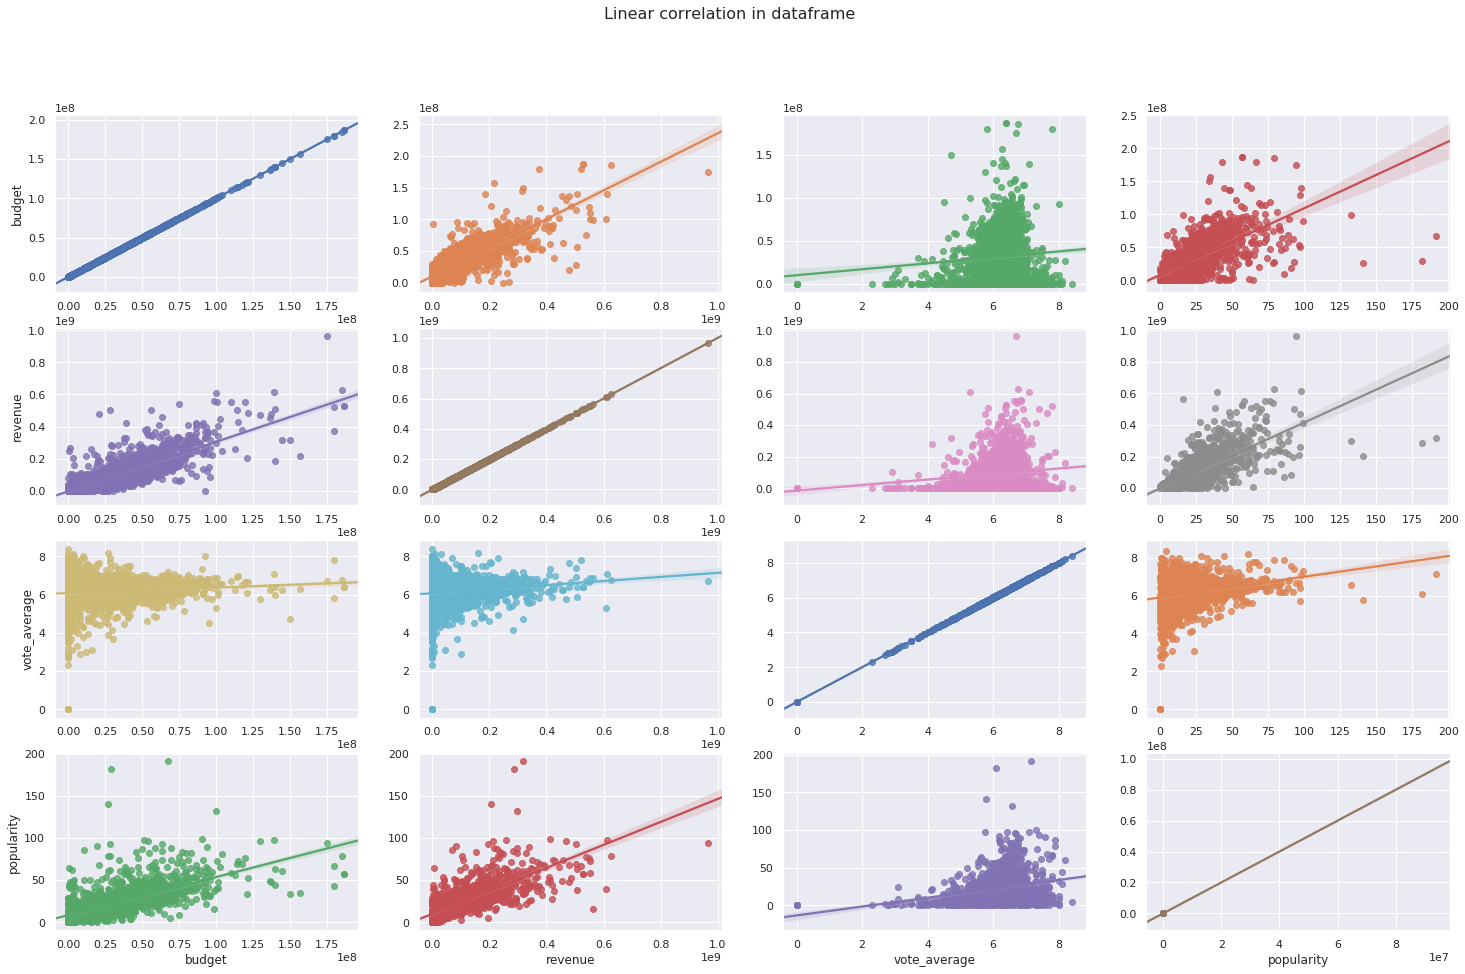

In [5]:
actors_dataset_no_com_df = actors_dataset_df.drop(columns = "community")
fig, ax = plt.subplots(4, 4, figsize=FIGSIZESUB)
fig.suptitle("Linear correlation in dataframe", fontsize=16)
for i, col1 in enumerate(["budget", "revenue", "vote_average", "popularity"]):
    for j, col2 in enumerate(["budget", "revenue", "vote_average", "popularity"]):
        sns.regplot(x=col2, y=col1, data=actors_dataset_no_com_df, ax=ax[i, j])
        if j > 0:
            ax[i, j].set_ylabel('') 
        if i < 3:
            ax[i, j].set_xlabel('')
plt.savefig("plots/correlation_scatter.pdf")

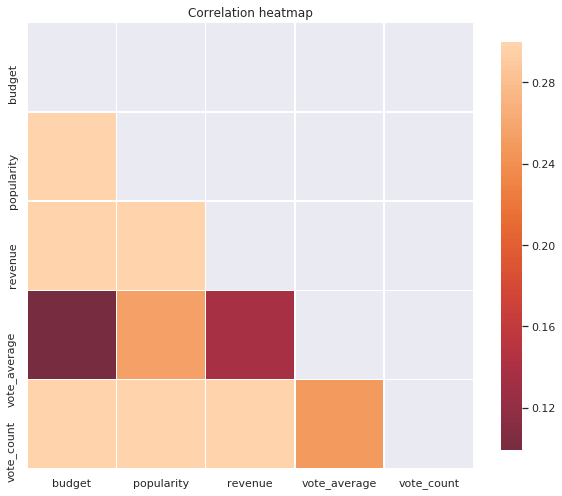

In [6]:
# Correlation heatmap
corr = actors_dataset_no_com_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set(title='Correlation heatmap')
sns.heatmap(corr, mask=mask, vmax=.3, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.savefig("plots/correlation_heatmap.pdf")

### Predict features

In [7]:
seed=10
test_size = 0.2

### Predict budget

In [8]:
y_budget_pred, budget_nmae, _ = get_linear_reg_results(X_budget,y_budget,test_size,seed)
print("Normalized MAE budget: "+str(budget_nmae))

Normalized MAE budget: 0.053693608433576824


### Predict budget using communities

In [9]:
y_budget_com_pred, budget_com_nmae, _ = get_linear_reg_results(X_budget_com,y_budget_com,test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.0502339850308759


In [10]:
print("Improvement percentage of budget prediction using communities: " +str((budget_nmae-budget_com_nmae)*100/budget_nmae)+" %")

Improvement percentage of budget prediction using communities: 6.443268581922086 %


### Predict revenue 

In [11]:
y_revenue_pred, revenue_nmae, _ = get_linear_reg_results(X_revenue,y_revenue,test_size,seed)
print("Normalized MAE revenue: "+str(revenue_nmae))

Normalized MAE revenue: 0.04477730964638722


### Predict revenue using communities

In [12]:
y_revenue_com_pred, revenue_com_nmae, _ = get_linear_reg_results(X_revenue_com,y_revenue_com,test_size,seed)
print("Normalized MAE revenue: "+str(revenue_com_nmae))

Normalized MAE revenue: 0.0439917535295413


In [13]:
print("Improvement percentage of revenue prediction using communities: " +str((revenue_nmae-revenue_com_nmae)*100/revenue_nmae)+" %")

Improvement percentage of revenue prediction using communities: 1.7543620263244262 %


### Predict popularity 

In [14]:
y_popularity_pred, popularity_nmae, _ = get_linear_reg_results(X_popularity,y_popularity,test_size,seed)
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.026673739820052604


### Predict popularity using communities

In [15]:
y_popularity_com_pred, popularity_com_nmae, _ = get_linear_reg_results(X_popularity_com,y_popularity_com,test_size,seed)
print("Normalized MAE popularity: "+str(popularity_com_nmae))

Normalized MAE popularity: 0.026545088891826187


In [16]:
print("Improvement percentage of popularity prediction using communities: " +str((popularity_nmae-popularity_com_nmae)*100/popularity_nmae)+" %")

Improvement percentage of popularity prediction using communities: 0.482313050567062 %


### Predict vote average

In [17]:
y_vote_average_pred, vote_average_nmae, _ = get_linear_reg_results(X_vote_average,y_vote_average,test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_nmae))

Normalized MAE vote average: 0.0833807153143487


### Predict vote average using communities

In [18]:
y_vote_average_com_pred, vote_average_com_nmae, _ = get_linear_reg_results(X_vote_average_com,y_vote_average_com,test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.08337235041014814


In [19]:
print("Improvement percentage of vote average prediction using communities: " +str((vote_average_nmae-vote_average_com_nmae)*100/vote_average_nmae)+" %")

Improvement percentage of vote average prediction using communities: 0.010032180905407726 %
